Last Updated: Jan 02, 2023


In this notebook, we run `scipy.optimize.minimize` to estimate $\sigma_8$ based on different covariance matrices of simulations and their mean values. The goal is to see how the bias of the mean values and the increased covariances affect parameter estimation. We first set up a toy example where we set all of the cosmology to be the same and only sample over $\sigma_8$. 

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "64" #need to be set early

In [2]:
#auto load changes 
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [3]:
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0,'/global/homes/t/tanveerk/SkyLens/') #path to skylens
sys.path.insert(0,'/global/homes/t/tanveerk/SkyLens/skylens') #path to skylens
sys.path.insert(0,'/global/homes/t/tanveerk/lselgsXplanck/src/') #path to helper functions

import skylens
import utilsCross #helper functions

from scipy.optimize import minimize

skylens main: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py


In [4]:
#import multiprocessing
from distributed import LocalCluster
from dask.distributed import Client
from dask.distributed import Lock

## Set up theory code

In [5]:
ndask_workers=2
LC,scheduler_info = skylens.start_client(ncpu=None,n_workers=ndask_workers,threads_per_worker=1,
                               memory_limit='60gb',dashboard_address=8801,
                               processes=True)
client=skylens.client_get(scheduler_info=scheduler_info)
print('client: ',client)#,dask_dir,scheduler_info)
 
lock = None #Lock(name="Why_Camb_Why",client=client)

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid39284/
client:  <Client: 'tcp://127.0.0.1:46345' processes=2 threads=2, memory=120.00 GB>


#### Skylens setup

Setup cosmology. For testing, we set everything to Planck18 except $A_s$. 

In [6]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo_planck

cosmo_fid=dict({'h':cosmo_planck.h,
                'Omb':cosmo_planck.Ob0,
                'Omd':cosmo_planck.Om0-cosmo_planck.Ob0,
                #'s8':0.817,
                'Om':cosmo_planck.Om0,
                #'Ase9':2.2,
                'mnu':0,
                'Omk':cosmo_planck.Ok0,
                'tau':0.06,
                'ns':0.965,
                'OmR':cosmo_planck.Ogamma0+cosmo_planck.Onu0,
                'w':-1,
                'wa':0,
                'T_cmb':cosmo_planck.Tcmb0, 
                'Neff':cosmo_planck.Neff,
                'z_max':1090,
                'use_astropy':True})

In [7]:
pk_params={'non_linear':1,
           'kmax':10,
           'kmin':3.e-4,
           'nk':500,
           'scenario':'dmo', 
           'halofit_version':'takahashi',
           'pk_func' :'camb_pk'}

In [8]:
cosmo_params = cosmo_fid

setup wigner file

In [9]:
wigner_files={} 
wigner_files[0]= '/pscratch/sd/t/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'
#wigner_files[0] = '/global/cscratch1/sd/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'

### Setup Skylens variables

In [10]:
test = True
if test:
    NSIDE = 256
    lmax_cl = 3 * NSIDE - 1
    binsize = 10
else:
    NSIDE = 1024
    #lmax_cl = 3 * NSIDE - 1
    lmax_cl = 3 * NSIDE - 1
    binsize = 50

In [11]:
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=50
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
#l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, binsize)
#lb=np.sqrt(l_bins[1:]*l_bins[:-1])
lb=0.5*(l_bins[1:]+l_bins[:-1])

l=l0

do_cov=False # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=True #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.
#window_lmax= 3*NSIDE - 1 #smaller value for testing. This should be 2X ell_max in the measurements.
window_lmax = 2*NSIDE

use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [12]:
def SkyLens_cls(nside, l, cosmo_params, pk_params,
                dndz_dict, gal_window_dict, gal_maskfile,
                cmb_SN_file, cmb_window_map_arr,
                z_cmb = 1090, zmax_cmb = 1090,
                bg1 = None, bz1 = None, mag_fact = 0, 
                zmin_gal = 0.0, zmax_gal = 1.6, nz = 140, 
                use_window = False,
                Win = None):
    """Returns Skylens object for C_ell calculation based on given maps.
    
    Inputs:
        nside (int) : nside for healpy
        l (array) : multipoles to evaluate 
        dndz_dict (dict) : dictionary containing dndz file location per tomographic bin
        gal_window_dict (dict) : dictionary containing galaxy window function file 
                                location per tomographic bin
        gal_maskfile (str) : Galaxy mask file location
        cmb_SN_file (str) : CMB noise curve file location 
        cmb_window_map_arr (str) : CMB window function file location
        z_cmb (float) : redshift of CMB 
        zmax_cmb (float) : maximum redshift where CMB lensing kernel should be integrated up to
        bg1 (float) : linear bias term for galaxies
        bz1 (dict) : redshift dependent galaxy bias
        mag_fact (float) : magnification bias 
        zmin_gal (float) : min redshift for galaxy sample
        zmax_gal (float) : max redshift for galaxy sample
        nz (int) : number of redshifts where P(k) will be evaluated
        use_window (bool) : whether to evaluate window function
        Win (dict) : optional dict; pass saved window calculated before
        
    Returns:
        kappa0 (dict) : Skylens dict containing Cls, pCls, coupling matrices
    """
    
    results = {}
            
    #tomographed redshift bins for the galaxies
    zl_bin = utilsCross.DESI_elg_bins(l=l, nside = nside, ntomo_bins = len(gal_window_dict), 
                                 bg1 = bg1, bz1 = bz1, mag_fact = mag_fact, 
                                 dndz_arr = dndz_dict, 
                                 gal_maskfile = gal_maskfile, gal_window_arr = gal_window_dict,
                                use_window = use_window)

    np.array([cmb_window_map_file])
    #redshift bins for cmb
    zs_bin = utilsCross.cmb_bins_here(zs = z_cmb, l=l, nside = nside, 
                                 zmax_cmb = zmax_cmb, SN_file = cmb_SN_file, 
                                 cmb_window_map_arr = cmb_window_map_arr,
                                use_window = use_window) # lensing source bin
    
    #names of maps
    #corr_kk=('kappa','kappa')
    corr_gg=('galaxy','galaxy')
    corr_gk=('galaxy','kappa')
    #corrs=[corr_kk, corr_gg, corr_gk]
    corrs = [corr_gg, corr_gk]
    
    #tmpz1 = np.linspace(max(zmin_gal, 1e-4), zmax_gal, nz)
    tmpz1 = np.linspace(0.01, zmax_gal + 0.5, nz)
    #tmpz2 = np.logspace(-4, np.log10(zmax_cmb), nz) #
    #z_PS = np.sort(np.unique(np.around(np.append(tmpz1, tmpz2), 
    #                                   decimals = 3))) #redshifts where P(k) will be evaluated
    z_PS = tmpz1
    print("z_PS: ", len(z_PS))
    
    if Win is not None:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, 
                                 galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
        
    else:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
    
    return kappa0

### Theory calculation setup

In [13]:
wtype = 'nnp' #window type 
cmb_SN_file = '/pscratch/sd/t/tanveerk/cmb/lensing/MV/nlkk.dat'
#cmb_SN_file = '/global/cscratch1/sd/tanveerk/cmb/lensing/MV/nlkk.dat'
gal_maskfile = '/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_bool_dr9.npy'
cmb_window_map_file = np.array(['/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_rotated_eq_nside_1024.npy'])
gal_window_map_file = "/global/homes/t/tanveerk/lselgsXplanck/finalproducts/Wg_map_nnp.npy"
gal_window_dict = np.array([gal_window_map_file])

#dndz file
redz_file = pd.read_csv("/global/homes/t/tanveerk/lselgsXplanck/finalproducts/fuji_pz_single_tomo.csv")
dndz = {}
dndz['zrange'] = np.array(redz_file['Redshift_mid'])
dndz['dndz'] = np.array(redz_file['pz'])
zrange = dndz['zrange']

Define galaxy linear bias and magnification bias

In [14]:
cosmo_params2 = deepcopy(cosmo_params)
cosmo_params2['Ase9'] = 2.2

In [15]:
def bz(b0, z, cosmo_params):
    """
    Returns galaxy bias as a function of cosmology, and b0
    """
    
    tmpcosmo = skylens.cosmology(cosmo_params=cosmo_params)

    bz1 = {}
    bz1[0] = b0/tmpcosmo.DZ_int(z=z)
    
    return bz1

In [16]:
#define cosmology object
bg1 = None
bz1 = bz(1, zrange, cosmo_params2)
mag_fact = 2.621 # set magnification bias ##FIXME: need to change it based on Rongpu's method

In [17]:
kappa0 = SkyLens_cls(nside = NSIDE, l = l, cosmo_params=cosmo_params2, pk_params=pk_params,
                dndz_dict = dndz, gal_window_dict = gal_window_dict, gal_maskfile = gal_maskfile,
                cmb_SN_file = cmb_SN_file, cmb_window_map_arr = cmb_window_map_file,
                z_cmb = 1090, zmax_cmb = 1090,
                bg1 = None, bz1 = bz1, mag_fact = mag_fact, 
                zmin_gal = 0.0, zmax_gal = 3, nz = 140, 
                use_window = use_window,
                Win = None)

0.0 3.000000000000001 None 0.0029767682558078574
cmb yes
processing cmb lensing window
z_PS:  140


/global/homes/t/tanveerk/lselgsXplanck/src/utilsCross.py:55: RuntimeWarning: invalid value encountered in sqrt
  window_map_noise = np.sqrt(window_map)


Tracer utils has tracers:  ['galaxy', 'kappa']


/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  z_max_all=np.array([self.z_bins[tracer]['zmax'] for tracer in self.tracers])
/global/homes/t/tanveerk/SkyLens/skylens/angular_power_spectra.py:27: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


power spectra camb_pk
True
Win gen: step size 265 767 513.0 2
wigner_files: {0: '/pscratch/sd/t/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 3.457069396972656e-05
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
set window_cl: cl done 4.1428539752960205 302.079 0.0
cl+cov bags done 2 0 4.21996545791626
set_window_cl done 5.477092266082764
setting windows, coupling matrices  <Client: 'tcp://127.0.0.1:46345' processes=2 threads=2, memory=120.00 GB>
doing lm 0
done lm cl+cov graph 0 0.00047469139099121094 704.733 tcp://127.0.0.1:34249
done lm 0 0.17464447021484375
doing lm 265
done lm cl+cov graph 265 0.0005927085876464844 704.733 tcp://127.0.0.1:39721
done lm 265 0.1743910312652588
doing lm 530
done lm cl+cov graph 530 0.0007717609405517578 704.733 tcp://127.0.0.1:34249
done lm 530 5.812072038650513
Done all lm 5.812733888626099
done combine lm 6.4825239181518

Save Window for future use.

In [18]:
Win = kappa0.Win
with open('/pscratch/sd/t/tanveerk/final_data_products/Window_NSIDE256_20230102.pickle', 'wb') as handle:
    pickle.dump(Win, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Calculate model using `tomo_short`

In [18]:
def assign_zparams(zbins={},par_name='',par_value=None):
    """Updates bias based on proposal"""
    
    pp=par_name.split('_')
    p_n=pp[0]
    bin_indx=np.int(pp[1])
    zbins[bin_indx][p_n]=par_value[0]
    return zbins


def get_params(proposal_params, cosmo_params, kappa0, z_bins,
              cosmo_params_to_infer = None): #FIXME: need to get params_order user-defined
    """Returns parameters to pass to tomo_short"""
    
    tmp_cosmo_params = deepcopy(cosmo_params)
    Ang_PS = kappa0.Ang_PS
    zbins = deepcopy(z_bins)
    
    # set number of bias parameters
    if cosmo_params_to_infer is None:
        params_order=['bz1_{i}'.format(i=i) for i in np.arange(kappa0.tracer_utils.z_bins['galaxy']['n_bins'])]
    else:
        params_order=['bz1_{i}'.format(i=i) for i in np.arange(kappa0.tracer_utils.z_bins['galaxy']['n_bins'])]
        params_order = params_order + cosmo_params_to_infer # concatenate parameters
    
    i=0
    for p in params_order:
        if cosmo_params.get(p) is not None:
            tmp_cosmo_params[p] = proposal_params[i]
        else:
            proposed_bias = bz(b0 = proposal_params[i], 
                               z = zbins['galaxy']['zp'][0], #FIXME: [0] because only one bin. For multi bin need to fix
                               cosmo_params = tmp_cosmo_params) # because of this order, cosmo params must come before b0
            
            zbins['galaxy']=assign_zparams(zbins=zbins['galaxy'], par_name=p, par_value = proposed_bias)
        i+=1
    return tmp_cosmo_params, zbins, Ang_PS
    

def get_model(proposal_params, cosmo_params, corrs, kappa0, z_bins, Win,
             WT, WT_binned, cl_bin_utils, xi_bin_utils = None,
             cosmo_params_to_infer = None):
    """
    Returns pseudo C_ell given input parameters
    
    Args
    ----
        proposal_params: proposal parameters - cosmological parameters must come before bias parameters 
        cosmo_params: all parameters
        corrs: tracers to evaluate
        kappa0: Skylens object
        z_bins: Skylens galaxy object to be updated for new bias proposals
        Win: Skylens Window object
        WT:
        WT_binned:
        cl_bin_utils:
        cosmo_params_to_infer: Besides galaxy bias, what other parameters to infer, e..g, A_s
    
    Returns
    ------
        model: pseudo-C_ells consisting of the corrs
    """
    
    cosmo_params_updated, z_bins_updated, Ang_PS = get_params(proposal_params, cosmo_params, kappa0, z_bins,
                                             cosmo_params_to_infer=cosmo_params_to_infer)
    
    model = kappa0.tomo_short(cosmo_params = cosmo_params_updated,
                              corrs = corrs,
                             z_bins = z_bins_updated,
                             Ang_PS = Ang_PS,
                             Win = Win,
                             WT = WT,
                             WT_binned = WT_binned,
                             cl_bin_utils = cl_bin_utils,
                             xi_bin_utils = xi_bin_utils)#,pk_lock=pk_lock)
    
    return model

Relevant Skylens parameters

In [19]:
zs_bin1 = deepcopy(client.gather(kappa0.tracer_utils.z_bins))

del_k=['window','window_cl']
for k in del_k:
    if zs_bin1['galaxy'].get(k) is not None:
        del zs_bin1['galaxy'][k]
    for i in np.arange(zs_bin1['galaxy']['n_bins']):
        if zs_bin1['galaxy'][i].get(k) is not None:
            del zs_bin1['galaxy'][i][k]

In [20]:
Win=kappa0.Win
WT = None
WT_binned = None
cl_bin_utils = client.gather(kappa0.cl_bin_utils)

In [21]:
corr_gg=('galaxy','galaxy')
corr_gk=('galaxy','kappa')
#corrs=[corr_kk, corr_gg, corr_gk]
corrs = [corr_gg, corr_gk]

## Setup data

### Load data

In [22]:
#declare window type and variable names
wintype = 'nnp'
exp_names = np.array(['A', 'B', 'C'])#, 'D', 'E', 'F'])
spectra = ['cgg', 'ckg']#, 'ckk']

In [23]:
#initalize dictionaries and arrays to save values
n_window = {}
pcls = {}

for exp in exp_names:
    n_window[exp] = np.zeros(1000)
    pcls[exp] = {}
    for spectrum in spectra:
        pcls[exp][spectrum] = np.zeros((1000, 1024))

In [24]:
count = 0
for h in range(10):
    stats = pickle.load(open( "/pscratch/sd/t/tanveerk/img-sys/stats/" + wintype + "/test_" + 
                              str(h) + "try_.npy", "rb" ))
    
    for i in range(len(stats['pcls'])):
        for j in range(5):
            idx = h * 100 + i * 5 + j                
            for k in exp_names:
                n_window[k][idx] = stats['window_noise'][i][j][k]
                for spectrum in spectra:
                    pcls[k][spectrum][idx] = stats['pcls'][i][j][spectrum][k]#[:1024]
            count += 1

### Bin data same way as theory

In [25]:
#calculate binned cls
cl_bu = cl_bin_utils #this contains all the relevant binning info
pclgg = skylens.bin_1d((pcls['A']['cgg'].mean(axis = 0) - n_window['A'].mean())[:3 * NSIDE - 1], bin_utils=cl_bu)
#pclkk = bin_1d(pcls['A']['ckk'].mean(axis = 0), bin_utils=cl_bu)
pclkg = skylens.bin_1d(pcls['A']['ckg'].mean(axis = 0)[:3 * NSIDE - 1], bin_utils=cl_bu)
data = np.concatenate((pclgg, pclkg))#, pclgg))

#bin for making covariance
pclgg_binned_arr = skylens.bin_1d((pcls['A']['cgg'] - n_window['A'].mean())[:,:3 * NSIDE - 1], bin_utils=cl_bu)
#pclkk_binned_arr = bin_1d(pcls['A']['ckk'], bin_utils=cl_bu)
pclkg_binned_arr = skylens.bin_1d(pcls['A']['ckg'][:,:3 * NSIDE - 1], bin_utils=cl_bu)

#covariance matrix
#cov = np.cov((pcls['A'] - fsky*nwindows['A'].mean()).T)
cov = np.cov(np.concatenate((pclgg_binned_arr, pclkg_binned_arr), axis = 1).T)
#_, cov = bin_mat(np.arange(1024), cov, np.arange(25, 1014, 100)) #bin covariance
cov_inv = np.linalg.inv(cov)

Text(0.5, 1.0, 'Binned correlation matrix [$C_{gg}, C_{\\kappa g}$]')

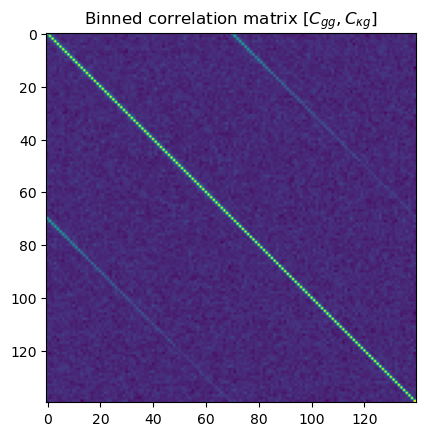

In [27]:
plt.imshow(np.corrcoef(np.concatenate((pclgg_binned_arr, pclkg_binned_arr), axis = 1).T))
plt.title(r"Binned correlation matrix [$C_{gg}, C_{\kappa g}$]")

## Inference step

 - In this step we define the Gaussian likelihood and solve for the different simulations. 
 - The idea is to run the inference step $1000$ times for each simulation and see how the MLE clusters. 

### Define $\chi^2$

In [28]:
def chisq(proposal_params, data, cov_inv, cosmo_params, corrs, kappa0, z_bins, Win,
         WT, WT_binned, cl_bin_utils, xi_bin_utils = None, 
         cosmo_params_to_infer = None):
    """
    Returns the Chi^2 based on a Gaussian likelihood.
    """
    
    model = get_model(proposal_params = proposal_params,
                      cosmo_params = cosmo_params,
                      corrs = corrs, kappa0 = kappa0, 
                      z_bins = z_bins, Win = Win,
                      WT = WT, WT_binned = WT_binned,
                      cl_bin_utils = cl_bin_utils,
                      xi_bin_utils = xi_bin_utils,
                     cosmo_params_to_infer=cosmo_params_to_infer)
    
    loss = data - model
    chisq = -0.5 * loss@cov_inv@loss
    
    return -1*chisq#, model

### Check how `tomo_short` works

Here we see that updating `Ase9` does not change `tomo_short`. So what is happening?

In [33]:
cosmo_params3 = deepcopy(cosmo_params2)
cosmo_params3['Ase9'] = 2.1

In [34]:
cosmo_params3['Ase9']

2.1

In [35]:
cosmo_params2['Ase9']

2.2

In [38]:
tmpAng_PS = kappa0.Ang_PS

In [39]:
tmp22 = kappa0.tomo_short(cosmo_params = cosmo_params3,
                              corrs = corrs,
                             z_bins = zs_bin1,
                             Ang_PS = tmpAng_PS,
                             Win = Win,
                             WT = WT,
                             WT_binned = WT_binned,
                             cl_bin_utils = cl_bin_utils,
                             xi_bin_utils = None)

/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:368: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


In [40]:
tmp104 = kappa0.tomo_short(cosmo_params = cosmo_params2,
                              corrs = corrs,
                             z_bins = zs_bin1,
                             Ang_PS = tmpAng_PS,
                             Win = Win,
                             WT = WT,
                             WT_binned = WT_binned,
                             cl_bin_utils = cl_bin_utils,
                             xi_bin_utils = None)

In [41]:
tmp22/tmp104

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

### Run sample inference with $b_0$ and $A_s$ parameters

Run inference on $b_0$

In [30]:
x0 = np.array([1.05])

In [35]:
%%timeit 
chisq(x0, data, cov_inv, cosmo_params2, corrs, kappa0, zs_bin1, Win, WT, WT_binned, cl_bin_utils, None, None)

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


36.2 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%timeit

minimize(fun = chisq, x0 = x0, 
         args=(data, cov_inv, cosmo_params2, corrs, kappa0, zs_bin1, Win,
              WT, WT_binned, cl_bin_utils, None, None),
        bounds=((0.9, 1.1),))

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


863 ms ± 976 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Run inference on $b_0$ and $A_s$

In [87]:
x0 = np.array([1., 2.19])

In [88]:
%time minimize(fun = chisq, x0 = x0, args=(data, cov_inv, cosmo_params2, corrs, kappa0, zs_bin1, Win,WT, WT_binned, cl_bin_utils, None, ['Ase9']),bounds = ((0.95, 1.05), (2.17, 2.21)))

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:368: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


CPU times: user 17min 29s, sys: 8min 15s, total: 25min 45s
Wall time: 2min 4s


      fun: 4.277064950937694
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.25357663, 11.12220518])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 177
      nit: 12
     njev: 59
   status: 0
  success: True
        x: array([1.00981575, 2.19361737])

In [89]:
%time minimize(fun = chisq, x0 = x0, args=(data, cov_inv, cosmo_params2, corrs, kappa0, zs_bin1, Win,WT, WT_binned, cl_bin_utils, None, ['Ase9']))

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to re

CPU times: user 50min 24s, sys: 23min 51s, total: 1h 14min 16s
Wall time: 5min 56s


      fun: 4.298359791127828
 hess_inv: array([[ 4.49058460e-06, -2.11264414e-07],
       [-2.11264414e-07,  2.90402410e-07]])
      jac: array([0.43318009, 4.47056466])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 509
      nit: 10
     njev: 165
   status: 2
  success: False
        x: array([1.01038604, 2.19135253])

## Run inference on all simulations

### Inference over $b_0$

In [79]:
x0 = np.array([1.05])

In [80]:
NSIMS = 1000
bias_estimated = {}

for exp in exp_names:
    bias_estimated[exp] = np.zeros(NSIMS)
    
    for i in range(NSIMS):
        pclgg = skylens.bin_1d((pcls[exp]['cgg'].mean(axis = 0) - n_window[exp].mean())[:3 * NSIDE - 1], bin_utils=cl_bu)
        pclkg = skylens.bin_1d(pcls[exp]['ckg'].mean(axis = 0)[:3 * NSIDE - 1], bin_utils=cl_bu)
        data_sim = np.concatenate((pclgg, pclkg))
    
        bias_estimated[exp][i] = minimize(fun = chisq, x0 = x0, 
                                 args=(data_sim, cov_inv, cosmo_params2, corrs, kappa0, zs_bin1, Win,
                                       WT, WT_binned, cl_bin_utils, None, None))['x']

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


### Inference over $b_0$ and $A_s$

In [29]:
x0 = np.array([1.05, 2.25])

In [30]:
from time import time

In [ ]:
NSIMS = 50
bias_estimated = {}

start = time()

for exp in ['A', 'C']:
    bias_estimated[exp] = np.zeros((NSIMS, 2))
    
    for i in range(NSIMS):
        pclgg = skylens.bin_1d((pcls[exp]['cgg'].mean(axis = 0) - n_window[exp].mean())[:3 * NSIDE - 1], bin_utils=cl_bu)
        pclkg = skylens.bin_1d(pcls[exp]['ckg'].mean(axis = 0)[:3 * NSIDE - 1], bin_utils=cl_bu)
        data_sim = np.concatenate((pclgg, pclkg))
    
        bias_estimated[exp][i] = minimize(fun = chisq, x0 = x0, 
                                          args=(data, cov_inv, cosmo_params2, corrs, kappa0, 
                                                zs_bin1, Win,WT, WT_binned, 
                                                cl_bin_utils, None, ['Ase9']),
                                          bounds = ((0.95, 1.05), (2.15, 2.25)))['x']
        
print(f"Time took {time() - start} seconds.")

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:368: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


In [33]:
bias_estimated

{'A': array([[1.00978479, 2.19361701],
        [1.00978479, 2.19361701]]),
 'B': array([[1.00978479, 2.19361701],
        [1.00978479, 2.19361701]]),
 'C': array([[1.00978479, 2.19361701],
        [1.00978479, 2.19361701]])}